# 5. Clustering bird syllables

Finally, we can evaluate the two feature vectors that we extracted using Variance and Laplacian scores with the clustering method [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). Each feature vector is evaluated using the Silhouette metric score with euclidean distance calculation. This metric is useful if the ground truth labels are not known, allowing evaluation to be performed using the model itself. Silhouette score always ranges between -1 to 1 with a high score suggesting that the objects are well matched to their own cluster and poorly matched to their neighborhood clusters.

In [12]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy

import IPython.display as ipd
import librosa
import librosa.display
import soundfile as sf
import warnings

from kneed import DataGenerator, KneeLocator

import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score
warnings.filterwarnings('ignore')

Load the `dataset.csv` file and select the best features according to the Variance and Laplacian scores that have been computed in the previous notebook.

In [13]:
df = pd.read_csv('dataset.csv')
df = df.dropna() # Remove NaN values
# Reset the dataframe index
df = df.reset_index(drop=True)

# Create the feature vectors with the selected feature computed in the previous notebook
df_variance = df[['SRm', 'SBm', 'MFCC4', 'SCm', 'ZCRv', 'MFCC6', 'SRv', 'MFCC7', 'MFCC5','SFm', 'duration', 'ZCRm', 'MFCC8']]
print(f'Number of Variance features: {df_variance.shape[1]}')
df_laplacian = df[['SBm', 'SRm', 'MFCC4', 'SCm', 'MFCC5', 'MFCC7', 'SFMm', 'MFCC3','MFCC6', 'MFCC2', 'ZCRm', 'ZCRv', 'ENm']]
print(f'Number of Laplacian features: {df_laplacian.shape[1]}')

Number of Variance features: 13
Number of Laplacian features: 13


Normalize the selected features and visualize them in a 3D scatter plot

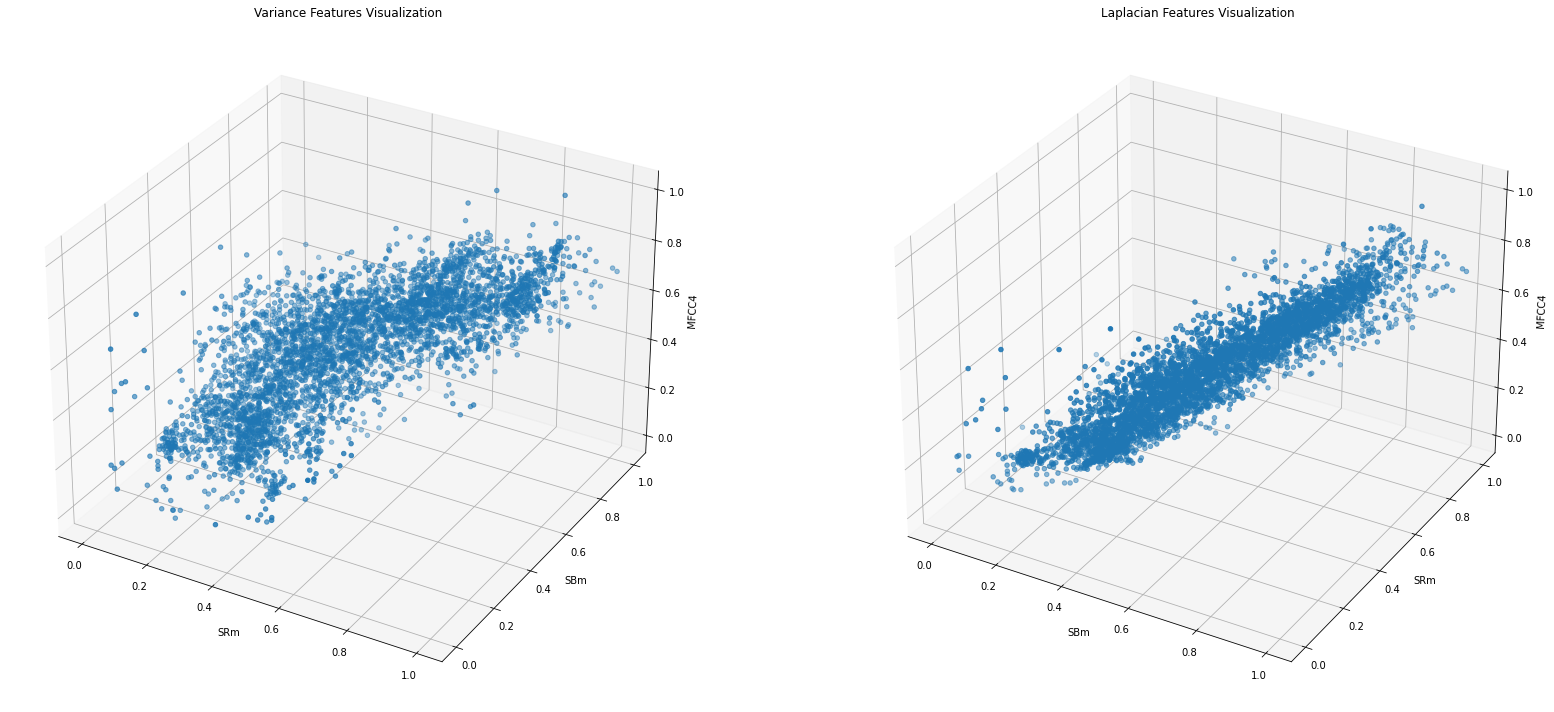

In [14]:
def normalizer(df):
    feature_vector = df.to_numpy()
    # Create a scaler object
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    # Apply scaler object to normalize feature vectors between 0 and 1
    features = scaler.fit_transform(feature_vector)
    return features

# Display the feature vectors on a 3D scatter plot    
fig = plt.figure(figsize=(25,10))

variance = normalizer(df_variance)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(variance[:,0], variance[:,1], variance[:,2])
ax.set_title('Variance Features Visualization')
ax.set_xlabel(df_variance.columns[0])
ax.set_ylabel(df_variance.columns[1])
ax.set_zlabel(df_variance.columns[2])

laplacian = normalizer(df_laplacian)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(laplacian[:,0], laplacian[:,1], laplacian[:,2])
ax.set_title('Laplacian Features Visualization')
ax.set_xlabel(df_laplacian.columns[0])
ax.set_ylabel(df_laplacian.columns[1])
ax.set_zlabel(df_laplacian.columns[2])

plt.tight_layout();

### Reducing dimensionality

The number of features should be chosen as small as possible in order to make the classifier more efficient. Features usually provide different discriminative power, but usually the goodness of a feature is not known. Also the diversity within birds syllables is large and it is likely that certain features that provide good discriminative power for one type of sounds may not be good for other types ([McIlraith & Card 1997](https://ieeexplore.ieee.org/document/650100)). Therefore it is justified to use specific features.

#### Non-linear dimensionality reduction

Manifold learning methods seek a lower-dimensional projection of high dimensional input that captures the salient properties of the input data. Some of the more popular methods include:

- Multi-Dimensional Scaling
- Isomap Embedding
- Spectral Embedding
- t-distributed Stochastic Neighbor Embedding

Each algorithm offers a different approach to the challenge of discovering natural relationships in data at lower dimensions. However, there is no best dimensionality reduction algorithm, and no easy way to find the best algorithm for our data without using controlled experiments. Here, we used a non-metric dimensionality reduction algorithm, namely the t-distributed stochastic neighbor embedding ([t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE)), to project the data in two dimensions ([Maaten L., et al. 2008](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)).



**t-distributed Stochastic Neighbor Embedding (t-SNE)**

t-SNE converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions. This allows t-SNE to be particularly sensitive to local structure and has a few other advantages over existing techniques:

- Revealing the structure at many scales on a single map
- Revealing data that lie in multiple, different, manifolds or clusters
- Reducing the tendency to crowd points together at the center

While Isomap, SE and variants are best suited to unfold a single continuous low dimensional manifold, t-SNE will focus on the local structure of the data and will tend to extract clustered local groups of samples as highlighted on the S-curve example. This ability to group samples based on the local structure might be beneficial to visually disentangle a dataset that comprises several manifolds at once as is the case in the digits dataset.

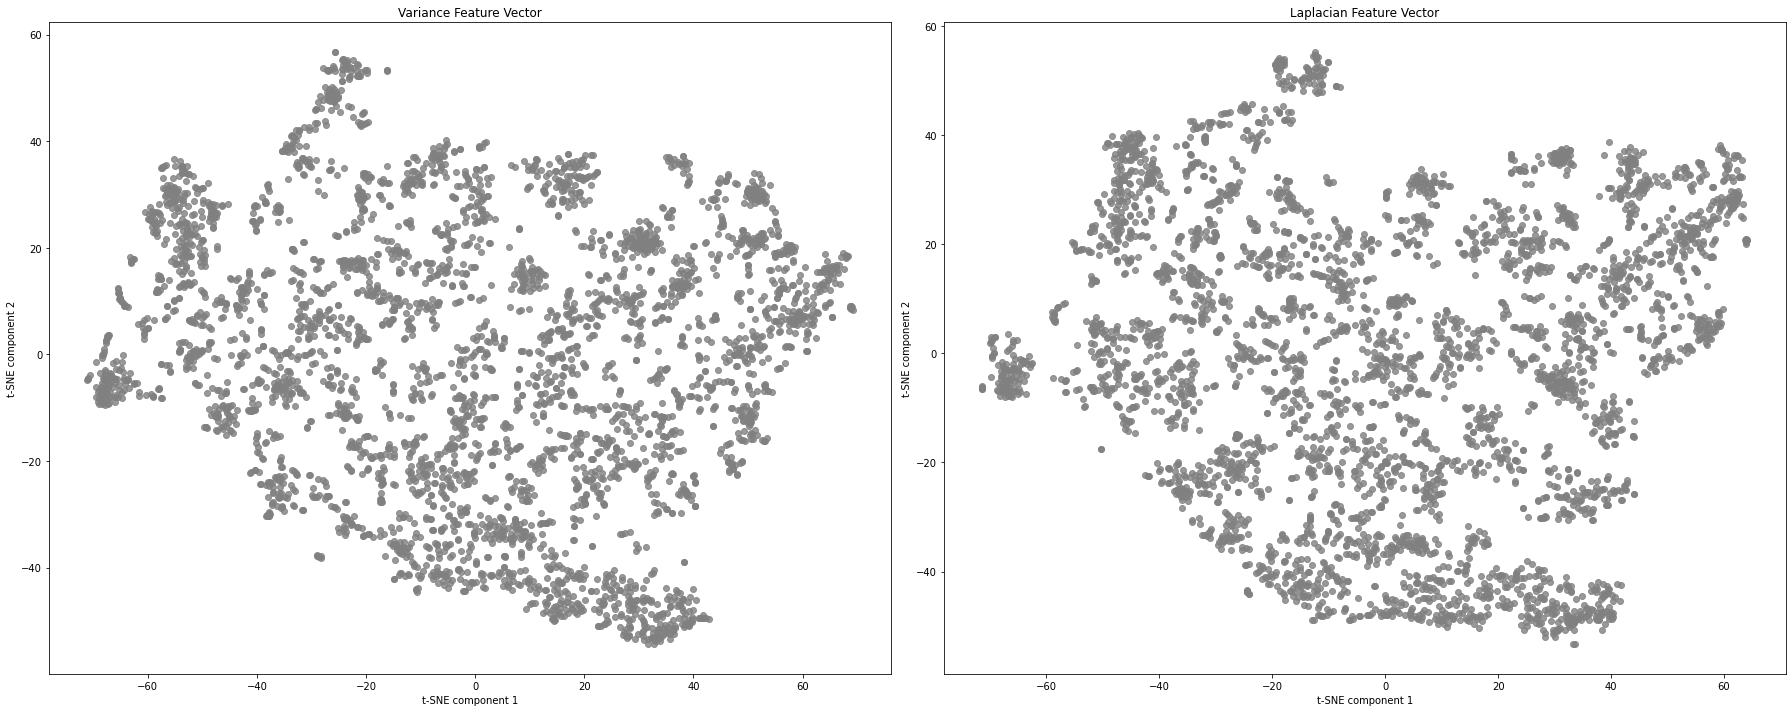

In [15]:
fig, ax = plt.subplots(1,2, figsize=(25,10))

tsne = sklearn.manifold.TSNE(n_components=2, perplexity=45, init='pca', n_iter=1500, learning_rate='auto')
X_tnse_var = tsne.fit_transform(variance)
ax[0].scatter(X_tnse_var[:,0], X_tnse_var[:,1], c='gray', alpha=0.8)
ax[0].set_title('Variance Feature Vector')
ax[0].set_xlabel('t-SNE component 1')
ax[0].set_ylabel('t-SNE component 2')
X_tnse_lap = tsne.fit_transform(laplacian)
ax[1].scatter(X_tnse_lap[:,0], X_tnse_lap[:,1], c='gray', alpha=0.8)
ax[1].set_title('Laplacian Feature Vector')
ax[1].set_xlabel('t-SNE component 1')
ax[1].set_ylabel('t-SNE component 2')
plt.tight_layout()
plt.show()

### Clustering of unlabeled data
**Density-Based Spatial Clustering of Applications with Noise (DBSCAN)**

As mentioned by [Amir Masoud Sefidian](https://www.sefidian.com/), every data mining task has the problem of parameters. Every parameter influences the algorithm in specific ways. For [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), the parameters `eps` and `min_samples` are needed. The parameters must be specified by the user. Ideally, the value of `eps` is given by the problem to solve (e.g. a physical distance), and `min_samples` is then the desired minimum cluster size. The method proposed here consists of computing the k-nearest neighbor distances in a matrix of points. The idea is to calculate, the average of the distances of every point to its k nearest neighbors. The value of k will be specified by the user and corresponds to `min_samples`. Next, these k-distances are plotted in ascending order. The aim is to determine the “elbow”, which corresponds to the optimal `eps` parameter.

Generally, `min_samples` should be greater than or equal to the dimensionality of the data set. In this study, the selected feature vector have 13 dimensions. Therefore, we use [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)’s default value of `min_samples=26` (Ester et al., 1996) as a starting point.

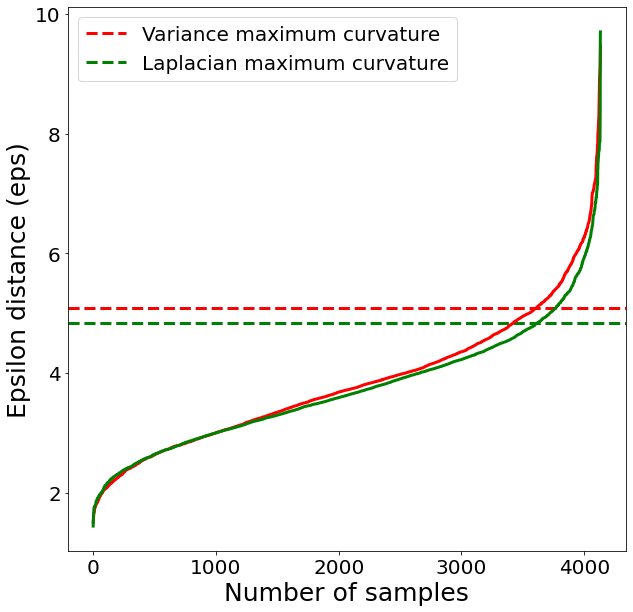

In [16]:
n_neighbors = 13*2 # Number of dimensions * 2
neighbors = NearestNeighbors(n_neighbors=n_neighbors)

neighbors_var = neighbors.fit(X_tnse_var)
distances_var, indices_var = neighbors_var.kneighbors(X_tnse_var)
distances_var = np.sort(distances_var, axis=0)
distances_var = distances_var[:,n_neighbors-1]
i = np.arange(len(distances_var))
knee_var = KneeLocator(i, distances_var, S=1, curve='convex', direction='increasing', interp_method='polynomial')
eps_var = distances_var[knee_var.knee]

neighbors_lap = neighbors.fit(X_tnse_lap)
distances_lap, indices_lap = neighbors_lap.kneighbors(X_tnse_lap)
distances_lap = np.sort(distances_lap, axis=0)
distances_lap = distances_lap[:,n_neighbors-1]
dist = np.arange(len(distances_lap))
knee_lap = KneeLocator(dist, distances_lap, S=1, curve='convex', direction='increasing', interp_method='polynomial')
eps_lap = distances_lap[knee_lap.knee]

plt.figure(figsize=(10,10))
plt.axhline(y=eps_var, color='r', linestyle='dashed', label='Variance maximum curvature', linewidth=3)
plt.axhline(y=eps_lap, color='g', linestyle='dashed', label='Laplacian maximum curvature', linewidth=3)
plt.plot(distances_var, color='r', linewidth=3)
plt.plot(distances_lap, color='g', linewidth=3)
plt.xlabel('Number of samples', fontsize=25)
plt.ylabel('Epsilon distance (eps)', fontsize=25)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
# plt.savefig('knee.jpg')

Variance -- Number of clusters found: 2 // Silhouette score: -0.12783530354499817
Laplacian -- Number of clusters found: 4 // Silhouette score: -0.17753161489963531

Variance -- Number of clusters found: 5 // Silhouette score: -0.13281741738319397
Laplacian -- Number of clusters found: 4 // Silhouette score: -0.1650436669588089

Variance -- Number of clusters found: 4 // Silhouette score: -0.08710131049156189
Laplacian -- Number of clusters found: 11 // Silhouette score: -0.04371587187051773

Variance -- Number of clusters found: 9 // Silhouette score: -0.05776253715157509
Laplacian -- Number of clusters found: 15 // Silhouette score: 0.1312759667634964

Variance -- Number of clusters found: 14 // Silhouette score: 0.27096959948539734
Laplacian -- Number of clusters found: 24 // Silhouette score: 0.2698523998260498

Variance -- Number of clusters found: 21 // Silhouette score: 0.29000672698020935
Laplacian -- Number of clusters found: 25 // Silhouette score: 0.33664047718048096

Varian

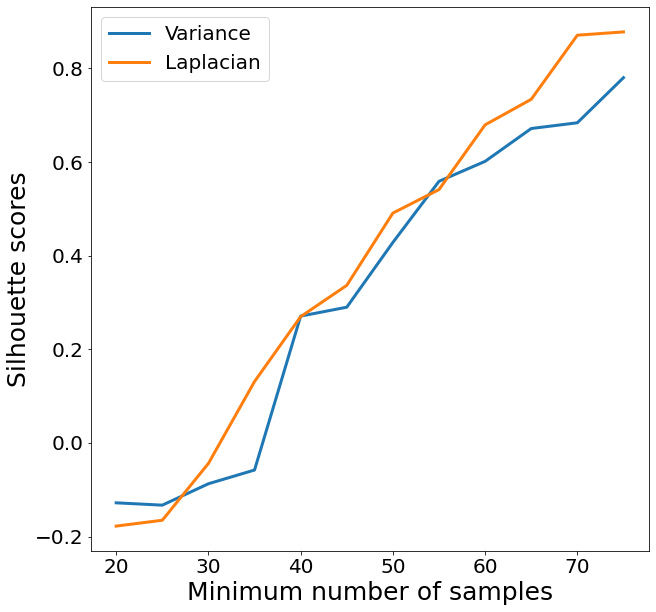

In [17]:
n_samples_var = []
sihlouette_var = []
n_samples_lap = []
sihlouette_lap = []

for samples in [20,25,30,35,40,45,50,55,60,65,70,75]:
    dbscan_var = sklearn.cluster.DBSCAN(eps=eps_var, min_samples=samples)
    label_var = dbscan_var.fit_predict(X_tnse_var)
    dbscan_lap = sklearn.cluster.DBSCAN(eps=eps_lap, min_samples=samples)
    label_lap = dbscan_lap.fit_predict(X_tnse_lap)
    
    noise_var_index = (dbscan_var.labels_ == -1)
    silhouette_per_sample_var = silhouette_samples(X_tnse_var, dbscan_var.labels_, metric='euclidean')
    silhouette_of_non_noise_var = silhouette_per_sample_var[~noise_var_index]
    n_samples_var.append(samples)
    sihlouette_var.append(silhouette_of_non_noise_var.mean())
        
    noise_lap_index = (dbscan_lap.labels_ == -1)
    silhouette_per_sample_lap = silhouette_samples(X_tnse_lap, dbscan_lap.labels_, metric='euclidean')
    silhouette_of_non_noise_lap = silhouette_per_sample_lap[~noise_lap_index]
    n_samples_lap.append(samples)
    sihlouette_lap.append(silhouette_of_non_noise_lap.mean())
    
    print(f"Variance -- Number of clusters found: {np.unique(dbscan_var.labels_).size-1} // Silhouette score: {silhouette_of_non_noise_var.mean()}")
    print(f"Laplacian -- Number of clusters found: {np.unique(dbscan_lap.labels_).size-1} // Silhouette score: {silhouette_of_non_noise_lap.mean()}\n")
    
# Plot the results
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(n_samples_var, sihlouette_var, linewidth=3, label='Variance')
plt.plot(n_samples_lap, sihlouette_lap, linewidth=3, label='Laplacian')
plt.xlabel('Minimum number of samples', fontsize=25)
plt.ylabel('Silhouette scores', fontsize=25)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
# plt.savefig('silhouette.jpg')

Number of bird syllables clusters found: 4
Number of noisy samples 3678 out of a total of 4133 samples

Silhouette Coefficient score: 0.8780001401901245


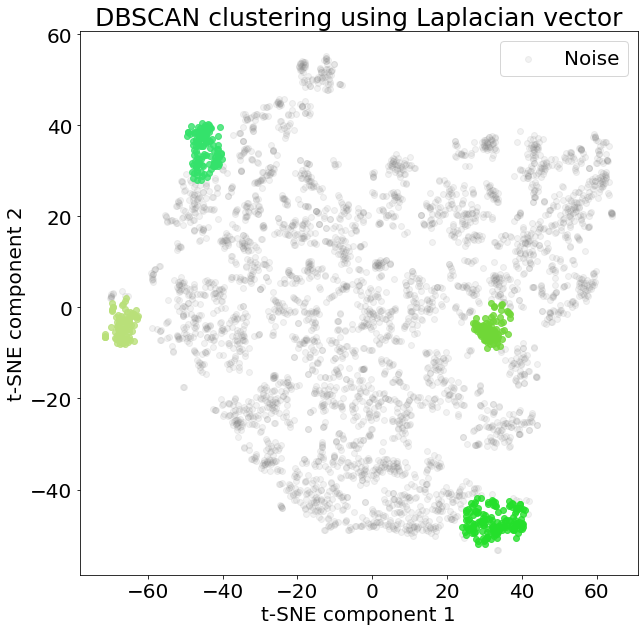

In [18]:
if max(sihlouette_var) > max(sihlouette_lap):
    idx = np.argsort(sihlouette_var)[-1] # maximum silhouette score index
    cluster = sklearn.cluster.DBSCAN(eps=eps_var, min_samples=n_samples_var[idx]).fit(X_tnse_var)
    selection = 'Variance'
else:
    idx = np.argsort(sihlouette_lap)[-1] # maximum silhouette score index
    cluster = sklearn.cluster.DBSCAN(eps=eps_lap, min_samples=n_samples_lap[idx]).fit(X_tnse_lap)
    selection = 'Laplacian'

print(f"Number of bird syllables clusters found: {np.unique(cluster.labels_).size-1}")
print(f"Number of noisy samples {len(cluster.labels_[cluster.labels_==-1])} out of a total of {len(cluster.labels_)} samples")
# Compute scores (output is in range 0 to 1 where 1 is best)
noise_features_index = (cluster.labels_ == -1)
silhouette_per_sample = silhouette_samples(X_tnse_lap, cluster.labels_, metric='euclidean')
silhouette_of_non_noise_samples = silhouette_per_sample[~noise_features_index]
print(f'\nSilhouette Coefficient score: {silhouette_of_non_noise_samples.mean()}')

fig, ax = plt.subplots(figsize=(10,10))
for lab_val in np.unique(cluster.labels_):    
    if lab_val == -1: # displaying noisy samples in white
        ax.scatter(X_tnse_lap[cluster.labels_==lab_val, 0], 
                   X_tnse_lap[cluster.labels_==lab_val, 1], c='grey', alpha=0.1, label='Noise')
        ax.legend()
    else:
        rgb = (random.random(), random.random(), random.random())
        ax.scatter(X_tnse_lap[cluster.labels_==lab_val, 0], X_tnse_lap[cluster.labels_==lab_val, 1], c=[rgb], alpha=0.8)

ax.set_title(f'DBSCAN clustering using {selection} vector', fontsize=25)
ax.set_xlabel('t-SNE component 1', fontsize=20)
ax.set_ylabel('t-SNE component 2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);
# plt.savefig('dbscan.jpg')

Finally, we can plot the spectrograms of the bird syllables found in the selected clusters and listen to them

Number of syllables found: 87


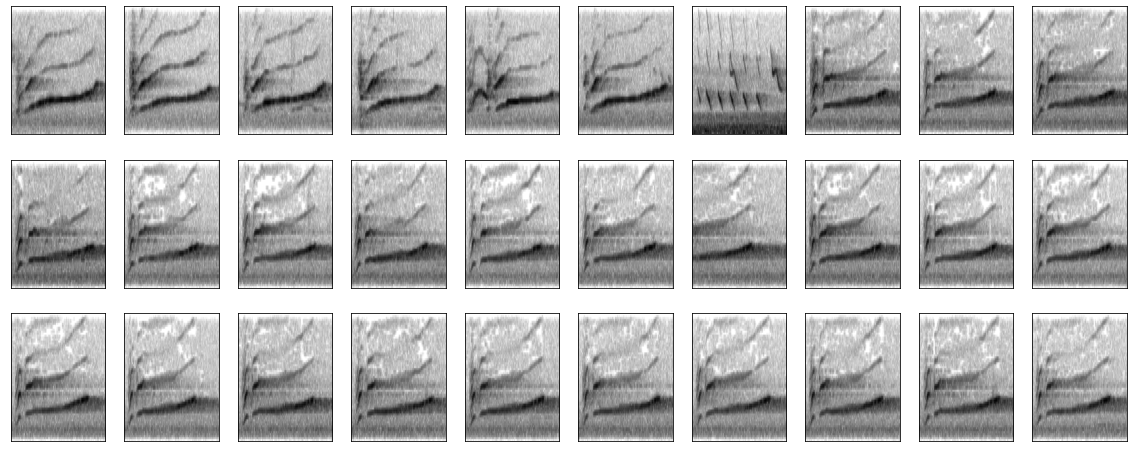

In [38]:
selected_cluster_idxs = np.asarray(np.where(cluster.labels_ == 0)).flatten()
print(f'Number of syllables found: {len(selected_cluster_idxs)}')

# Plot the spectrograms
fig, axes = plt.subplots(3,10, subplot_kw={'xticks':(), 'yticks':()}, figsize=(20,8))
for i, ax in zip(selected_cluster_idxs, axes.ravel()):
    y, sr = librosa.load(df['file-name'][i], sr=22050)
    S = np.abs(librosa.stft(y[df.start[i]:df.end[i]], n_fft=128))
    ax.imshow(librosa.amplitude_to_db(S, ref=np.max), cmap=plt.cm.binary, aspect='auto', norm=None, vmax=0, vmin=-80)
    ax.invert_yaxis()

In [8]:
selected_cluster_idxs = np.asarray(np.where(cluster.labels_ == 0)).flatten()[10:]
for x, i in enumerate(selected_cluster_idxs):
    y, sr = librosa.load(df['file-name'][i], sr=22050)
    ipd.display(ipd.Audio(y[df.start[i]:df.end[i]], rate=sr))
    if x == 9:
        break

Number of syllables found: 94


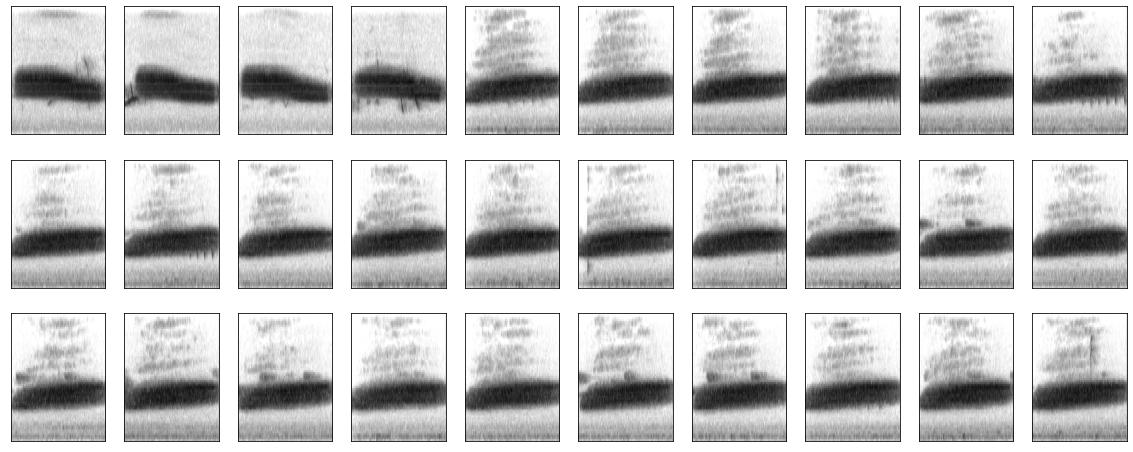

In [39]:
selected_cluster_idxs = np.asarray(np.where(cluster.labels_ == 1)).flatten()
print(f'Number of syllables found: {len(selected_cluster_idxs)}')

# Plot the spectrograms
fig, axes = plt.subplots(3,10, subplot_kw={'xticks':(), 'yticks':()}, figsize=(20,8))
for i, ax in zip(selected_cluster_idxs, axes.ravel()):
    y, sr = librosa.load(df['file-name'][i], sr=22050)
    S = np.abs(librosa.stft(y[df.start[i]:df.end[i]], n_fft=128))
    ax.imshow(librosa.amplitude_to_db(S, ref=np.max), cmap=plt.cm.binary, aspect='auto', norm=None, vmax=0, vmin=-80)
    ax.invert_yaxis()

In [9]:
selected_cluster_idxs = np.asarray(np.where(cluster.labels_ == 1)).flatten()[10:]
for x, i in enumerate(selected_cluster_idxs):
    y, sr = librosa.load(df['file-name'][i], sr=22050)
    ipd.display(ipd.Audio(y[df.start[i]:df.end[i]], rate=sr))
    if x == 9:
        break

Number of syllables found: 120


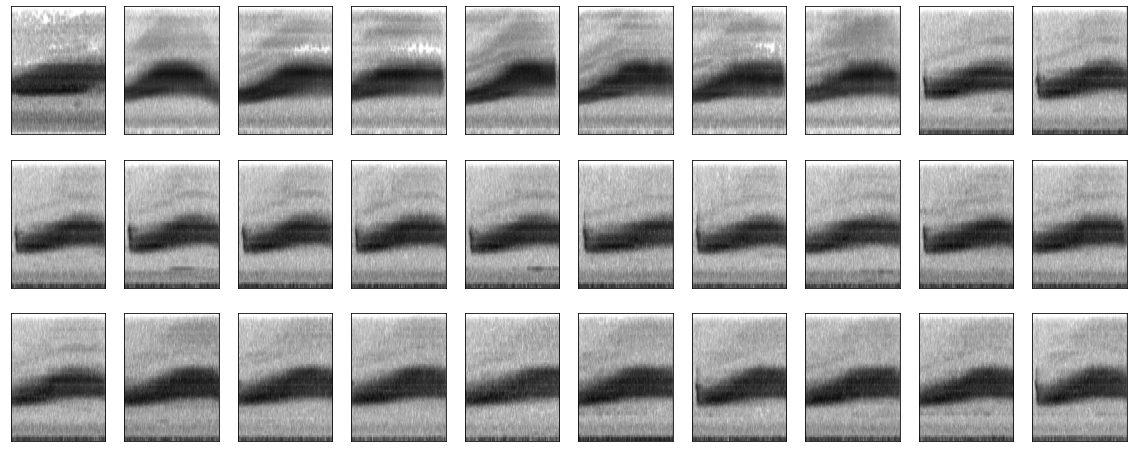

In [40]:
selected_cluster_idxs = np.asarray(np.where(cluster.labels_ == 2)).flatten()
print(f'Number of syllables found: {len(selected_cluster_idxs)}')

# Plot the spectrograms
fig, axes = plt.subplots(3,10, subplot_kw={'xticks':(), 'yticks':()}, figsize=(20,8))
for i, ax in zip(selected_cluster_idxs, axes.ravel()):
    y, sr = librosa.load(df['file-name'][i], sr=22050)
    S = np.abs(librosa.stft(y[df.start[i]:df.end[i]], n_fft=128))
    ax.imshow(librosa.amplitude_to_db(S, ref=np.max), cmap=plt.cm.binary, aspect='auto', norm=None, vmax=0, vmin=-80)
    ax.invert_yaxis()

In [10]:
selected_cluster_idxs = np.asarray(np.where(cluster.labels_ == 2)).flatten()[10:]
for x, i in enumerate(selected_cluster_idxs):
    y, sr = librosa.load(df['file-name'][i], sr=22050)
    ipd.display(ipd.Audio(y[df.start[i]:df.end[i]], rate=sr))
    if x == 9:
        break

Number of syllables found: 154


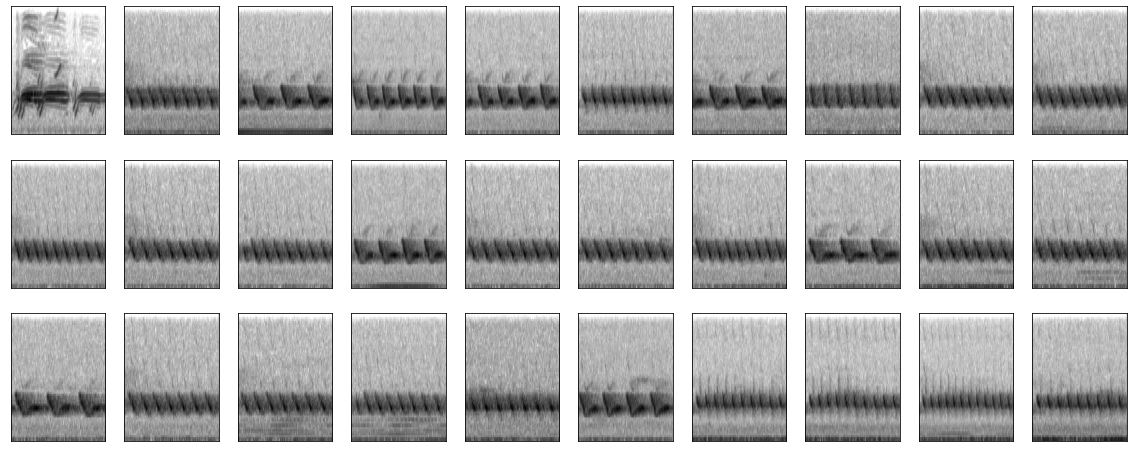

In [41]:
selected_cluster = 3
selected_cluster_idxs = np.asarray(np.where(cluster.labels_ == selected_cluster)).flatten()
print(f'Number of syllables found: {len(selected_cluster_idxs)}')

# Plot the spectrograms
fig, axes = plt.subplots(3,10, subplot_kw={'xticks':(), 'yticks':()}, figsize=(20,8))
for i, ax in zip(selected_cluster_idxs, axes.ravel()):
    y, sr = librosa.load(df['file-name'][i], sr=22050)
    S = np.abs(librosa.stft(y[df.start[i]:df.end[i]], n_fft=128))
    ax.imshow(librosa.amplitude_to_db(S, ref=np.max), cmap=plt.cm.binary, aspect='auto', norm=None, vmax=0, vmin=-80)
    ax.invert_yaxis()

In [11]:
selected_cluster_idxs = np.asarray(np.where(cluster.labels_ == 3)).flatten()[10:]
for x, i in enumerate(selected_cluster_idxs):
    y, sr = librosa.load(df['file-name'][i], sr=22050)
    ipd.display(ipd.Audio(y[df.start[i]:df.end[i]], rate=sr))
    if x == 9:
        break